Imports

In [12]:
!pip install sktime
!pip install pandas
!pip install seaborn
!pip install sklearn



In [13]:
from sktime.datasets import load_from_arff_to_dataframe
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import shutil


creating datasets and spliting

In [20]:
with zipfile.ZipFile("datasets.zip","r") as zip_ref:
    zip_ref.extractall()

In [15]:
X_train_sports, y_train_sports = load_from_arff_to_dataframe('RacketSports\RacketSports_TRAIN.arff')
X_test_sports, y_test_sports = load_from_arff_to_dataframe('RacketSports\RacketSports_TEST.arff')

data_mitbih_train = pd.read_csv('ECG\mitbih_train.csv', header=None)
data_mitbih_test = pd.read_csv('ECG\mitbih_test.csv', header=None)

X_train_mitbih = data_mitbih_train.iloc[:, 0:-1]
y_train_mitbih = data_mitbih_train.iloc[:, -1]

X_test_mitbih = data_mitbih_test.iloc[:, 0:-1]
y_test_mitbih = data_mitbih_test.iloc[:, -1]

print(y_train_mitbih.head(5))

data_ptbdb_abnormal = pd.read_csv('ECG\ptbdb_abnormal.csv', header=None)
data_ptbdb_normal = pd.read_csv('ECG\ptbdb_normal.csv', header=None)

data_ptbdb = pd.concat([data_ptbdb_abnormal, data_ptbdb_normal])

X_ptbdb = data_ptbdb.iloc[:, 0:-1]
y_ptbdb = data_ptbdb.iloc[:, -1]

X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.2, random_state=42)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 187, dtype: float64


(151,)
RacketSports
Train Set


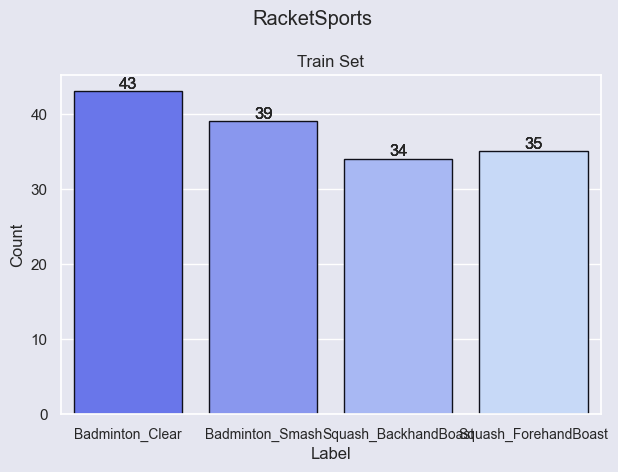

(152,)
RacketSports
Test Set


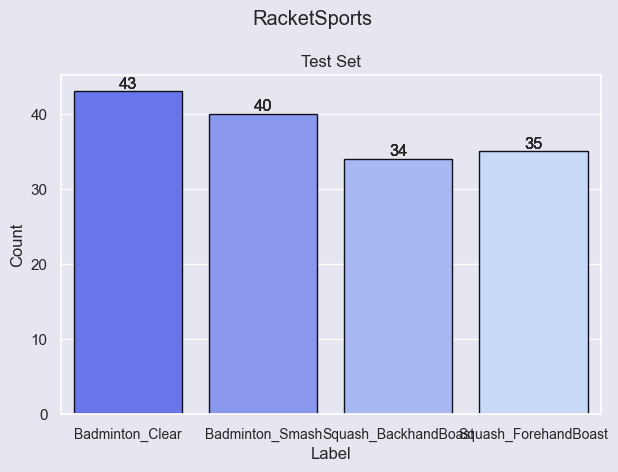

(87554,)
ECG Heartbeat Categorization Dataset - MIT-BIH
Train Set


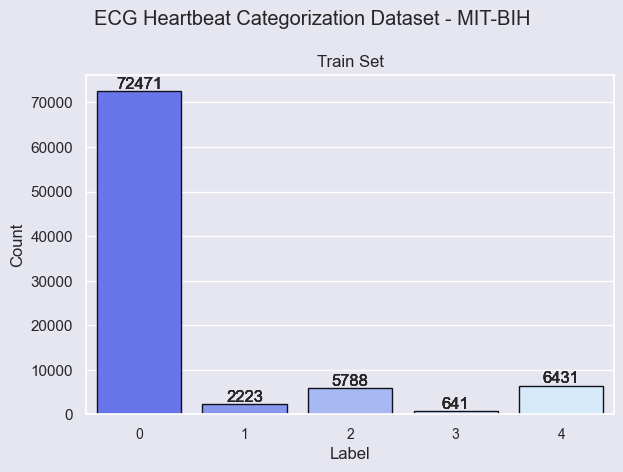

(21892,)
ECG Heartbeat Categorization Dataset - MIT-BIH
Test Set


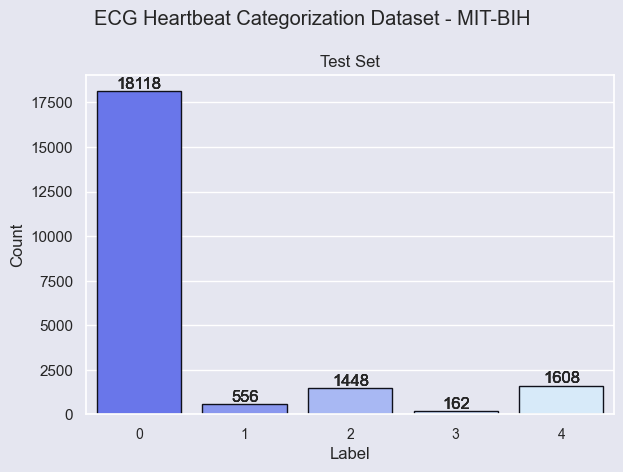

(11641,)
ECG Heartbeat Categorization Dataset - PTB Diagnostic
Train Set


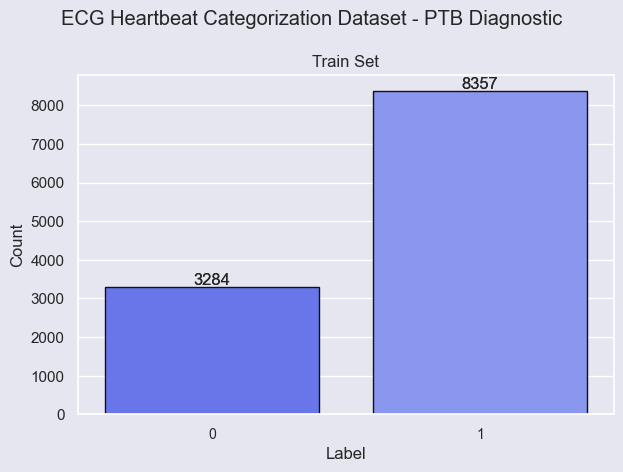

(2911,)
ECG Heartbeat Categorization Dataset - PTB Diagnostic
Test Set


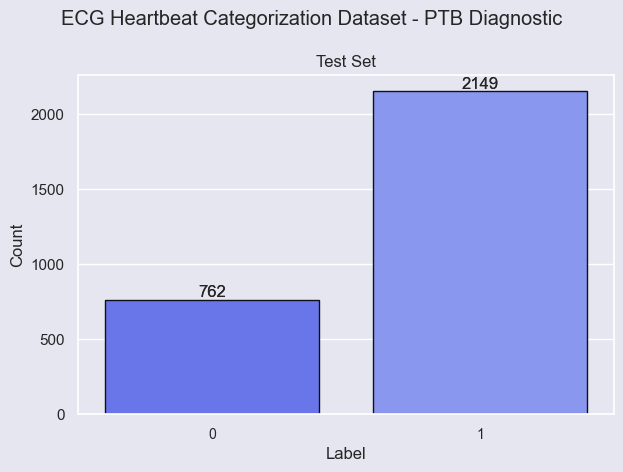

In [16]:
labels_sports = ['Badminton_Smash',
                'Badminton_Clear',
                'Squash_ForehandBoast',
                'Squash_BackhandBoast']

labels_mitbih = list(range(5))

# labels_ptbdb = ['normal', 'abnormal']
labels_ptbdb = [0, 1]

datasets = [y_train_sports, y_test_sports, y_train_mitbih, y_test_mitbih, y_train_ptbdb, y_test_ptbdb]

plot_labels = [labels_sports, labels_mitbih, labels_ptbdb]
plot_titles = ['RacketSports', 'ECG Heartbeat Categorization Dataset - MIT-BIH', 'ECG Heartbeat Categorization Dataset - PTB Diagnostic']
plot_subtitles = ['Train Set', 'Test Set']

sns.set(rc={'figure.autolayout': True})

bg_color = '#E5E6F0'
color_line = '#0F101A'
colors = ['#5465FF', '#788BFF', '#9BB1FF', '#BFD7FF', '#D1EAFF', '#E2FDFF']
sns.set_palette(sns.color_palette(colors))

for index in range(len(datasets)):
    print(datasets[index].shape)
    print(plot_titles[index // 2])
    print(plot_subtitles[index % 2])
    plt.figure(facecolor=bg_color)
    ax = sns.countplot(x=datasets[index], order=np.unique(plot_labels[index // 2]), edgecolor=color_line)
    ax.set_facecolor(bg_color)

    for p in ax.patches:
        ax.bar_label(container=ax.containers[0])

    plt.title(plot_subtitles[index % 2])
    plt.suptitle(plot_titles[index // 2])
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(fontsize=10)
    plt.show()

    # plang


In [17]:

# # # X.head()
# # # X["dim_5"]

# # # sns.set(rc={'figure.autolayout': True})
# # # Get the counts of each label

# # labels = {'Badminton_Smash' : 'Btn_Smash',
# #           'Badminton_Clear' : 'Btn_Clear',
# #           'Squash_ForehandBoast' : 'Sqh_Forehand',
# #           'Squash_BackhandBoast' : 'Sqh_Backhand'}
# # count = []

# # for label in labels:
# #     count.append(np.count_nonzero(y_Sports == label))

# # count = np.array(count)
# # labels_count = list(labels.values())

# # # Use seaborn to create a bar plot
# # sns.set(rc={'figure.autolayout': True})
# # sns.barplot(x=labels_count, y=count, palette='Set2')

# # # # Set the plot title and labels
# # plt.suptitle('ce e asta??')
# # plt.title('Frecvența de apariție a fiecărei etichete')
# # plt.xlabel('Labels')
# # plt.ylabel('Count')

# # # Set the font size of the x-axis labels
# # plt.xticks(fontsize=10)

# # # Display the plot
# # plt.show()



# # # X_mitbih, y_mitbih
# # count = []
# # labels_count = []
# # for label in range(5):
# #     count.append(np.count_nonzero(y_mitbih == label))
# #     labels_count.append(label)


# # count = np.array(count)
# # labels_count = np.array(labels_count)

# # # # Use seaborn to create a bar plot
# # sns.set(rc={'figure.autolayout': True})
# # sns.barplot(x=labels_count, y=count, palette='Set2')

# # # # # Set the plot title and labels
# # plt.suptitle('ce e asta??')
# # plt.title('Frecvența de apariție a fiecărei etichete')
# # plt.xlabel('Labels')
# # plt.ylabel('Count')

# # # # Set the font size of the x-axis labels
# # plt.xticks(fontsize=10)

# # # # Display the plot
# # plt.show()



In [18]:
# # TO DO for each label from dataset

# x_acc = X["dim_0"].to_numpy()
# y_acc = X["dim_1"].to_numpy()
# z_acc = X["dim_2"].to_numpy()


# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(x_acc[0], y_acc[0], z_acc[0])

# x_gir = X["dim_3"].to_numpy()
# y_gir = X["dim_4"].to_numpy()
# z_gir = X["dim_5"].to_numpy()


# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(x_gir[0], y_gir[0], z_gir[0])
# plt.show()



NameError: name 'X' is not defined

In [21]:
shutil.rmtree('ECG', ignore_errors=True)
shutil.rmtree('RacketSports', ignore_errors=True)

In [ ]:
#wtf wtf wtf wtf wtf